In [288]:
# import packages

# manipulation 
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
import missingno as msno
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.impute import SimpleImputer

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

# metrics
from sklearn.metrics import r2_score, mean_squared_error

RSEED = 394

In [289]:
# load data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Data Inspection

## Size of data

In [290]:
print(f"Shape of modelling dataset: {df_train.shape}")
print(f"Shape of prediction] dataset: {df_test.shape}")

Shape of modelling dataset: (30557, 82)
Shape of prediction] dataset: (16136, 77)


### Which columns differ? 

In [291]:
diff_cols = [col for col in df_train.columns if col not in df_test.columns]
diff_cols

['target', 'target_min', 'target_max', 'target_variance', 'target_count']

## Data features 

In [292]:
poll_cols = [col for col in df_train.columns if col.find('L3') != -1]
target_cols = [col for col in df_train.columns if col.find('target') != -1]
loc_cols = [col for col in df_train.columns if col.find('Place') != -1 or col.find('Date') != -1 ]
weather_cols = [col for col in df_train.columns if col not in poll_cols + target_cols + loc_cols ]

print(f"Number of columns related to:")
print(f"target: {len(target_cols)}")
print(f"pollution: {len(poll_cols)}")
print(f"location: {len(loc_cols)}")
print(f"weather: {len(weather_cols)}")


Number of columns related to:
target: 5
pollution: 68
location: 3
weather: 6


### How many places and dates do we have? 

In [293]:
df_train.Date.unique()
print(f"There are {df_train.Date.nunique()} dates between {df_train.Date.min()} and {df_train.Date.max()}.")

df_train.Place_ID.unique()
print(f"The number of places is {df_train.Place_ID.nunique()}.")

There are 94 dates between 2020-01-02 and 2020-04-04.
The number of places is 340.


In [294]:
print(f"We have {df_train.shape[0]} actual observations.")
print(f"If each place had the full 3 months of observations, we should have a sample size of {94 * 340}.")

print(f"\nThis means we do NOT have observations for each place-date pair.")

We have 30557 actual observations.
If each place had the full 3 months of observations, we should have a sample size of 31960.

This means we do NOT have observations for each place-date pair.


In [295]:
place_counts = df_train.groupby('Place_ID').Place_ID.count().unique()
print(f"A place appears between {place_counts.min()} and {place_counts.max()} times.")

A place appears between 3 and 94 times.


### How many pollutants do we have? 

In [296]:
# list_of_pollutants = [NO2, CH4, ....]
pollutants = list(set([pol.split('_')[1] for pol in df_train[poll_cols].columns]))
pollutants = [pol + "_AI" if pol == "AER" else pol for pol in pollutants]

pollutants

['HCHO', 'AER_AI', 'CH4', 'O3', 'CO', 'NO2', 'SO2', 'CLOUD']

## Target variables

In [297]:
df_train[target_cols].head()

,target,target_min,target_max,target_variance,target_count
0,38.0,23.0,53.0,769.50,92
1,39.0,25.0,63.0,1319.85,91
2,24.0,8.0,56.0,1181.96,96
3,49.0,10.0,55.0,1113.67,96
4,21.0,9.0,52.0,1164.82,95


# 2. Data preparation

## Split train and test

Later in this notebook, we perform within-place imputation of various pollutant-related variables. This means we must split dataset into train and test data such that each city appears _either_ in the train data _or_ the test data (but not both). 

We do this by randomly splitting the list of unique places. Based on this split, we then subset the entire dataset (place-date pairs). 

In [298]:
df = df_train.copy()

# split dataset into features and target
y = df[['target', 'Place_ID']]          # keep place_ID because we need it for the train/test split
X = df.drop(target_cols, axis = 1)

# obtain unique list of places
places = X.Place_ID.unique()

# split the cities into train and test
places_train, places_test = train_test_split(places, test_size=0.2, random_state=RSEED)

# filter the features for train and test cities
X_train = X[X['Place_ID'].isin(places_train)]
X_test = X[X['Place_ID'].isin(places_test)]

# filter the targets for train and test (+ drop the location variable)
y_train = y[y['Place_ID'].isin(places_train)].drop('Place_ID', axis = 1)
y_test = y[y['Place_ID'].isin(places_test)].drop('Place_ID', axis = 1)

# append features and targets for EDA
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

# display the shapes of train and test sets
print(f"Number of places in test is {len(places_test)} and in train {len(places_train)}.")
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Split percentage on set:", round(X_train.shape[0]/len(X)*100, 4), "%")


Number of places in test is 68 and in train 272.
Train set shape: (24533, 77)
Test set shape: (6024, 77)
Split percentage on set: 80.286 %


In [299]:
# drop all columns with satellite position information --> not relevant for prediction
useless_cols = [col for col in poll_cols if col.find('sensor') != -1 or col.find('solar') != -1]
print("The pollution features of interest are:")
print(useless_cols)

poll_cols = [col for col in poll_cols if col not in useless_cols]

X_train = X_train.drop(useless_cols, axis = 1)
X_test = X_test.drop(useless_cols, axis = 1)

The pollution features of interest are:
['L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle', 'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle', 'L3_NO2_solar_zenith_angle', 'L3_O3_sensor_azimuth_angle', 'L3_O3_sensor_zenith_angle', 'L3_O3_solar_azimuth_angle', 'L3_O3_solar_zenith_angle', 'L3_CO_sensor_altitude', 'L3_CO_sensor_azimuth_angle', 'L3_CO_sensor_zenith_angle', 'L3_CO_solar_azimuth_angle', 'L3_CO_solar_zenith_angle', 'L3_HCHO_sensor_azimuth_angle', 'L3_HCHO_sensor_zenith_angle', 'L3_HCHO_solar_azimuth_angle', 'L3_HCHO_solar_zenith_angle', 'L3_CLOUD_sensor_azimuth_angle', 'L3_CLOUD_sensor_zenith_angle', 'L3_CLOUD_solar_azimuth_angle', 'L3_CLOUD_solar_zenith_angle', 'L3_AER_AI_sensor_altitude', 'L3_AER_AI_sensor_azimuth_angle', 'L3_AER_AI_sensor_zenith_angle', 'L3_AER_AI_solar_azimuth_angle', 'L3_AER_AI_solar_zenith_angle', 'L3_SO2_sensor_azimuth_angle', 'L3_SO2_sensor_zenith_angle', 'L3_SO2_solar_azimuth_angle', 'L3_SO2_solar_zenith_angle', 'L3_CH4_sensor_azimuth_

# Exploratory data analysis & feature engineering

## Distributions of features

In [300]:
y_train.describe()

,target
count,24533.000000
mean,60.112779
std,47.344209
min,1.000000
25%,25.000000
50%,50.000000
75%,77.000000
max,815.000000


[here should be more code for distributions]

## Relationships among features

tbw

## Missing values

There are no missing values for location and weather variables. 

Polution related features have missing values, which are missing in groups on the pollutant level. For instance, if we have 6 variables for methane, values for an observation are either all missing or all non-missing.

We assess the missing values, finding that missing values are distributed across the entire 3-month period and across the different cities (i.e. we do _not_ have a situation in which only some cities or some months have observations for a pollutant). 

Hence, we decide to use linear interpolation for each pollutant on the city level over time. 

### Inspection

In [301]:
X_train.isnull().sum()

Place_ID X Date                                            0
Date                                                       0
Place_ID                                                   0
precipitable_water_entire_atmosphere                       0
relative_humidity_2m_above_ground                          0
specific_humidity_2m_above_ground                          0
temperature_2m_above_ground                                0
u_component_of_wind_10m_above_ground                       0
v_component_of_wind_10m_above_ground                       0
L3_NO2_NO2_column_number_density                        1750
L3_NO2_NO2_slant_column_number_density                  1750
L3_NO2_absorbing_aerosol_index                          1750
L3_NO2_cloud_fraction                                   1750
L3_NO2_stratospheric_NO2_column_number_density          1751
L3_NO2_tropopause_pressure                              1751
L3_NO2_tropospheric_NO2_column_number_density           6957
L3_O3_O3_column_number_d

<Axes: >

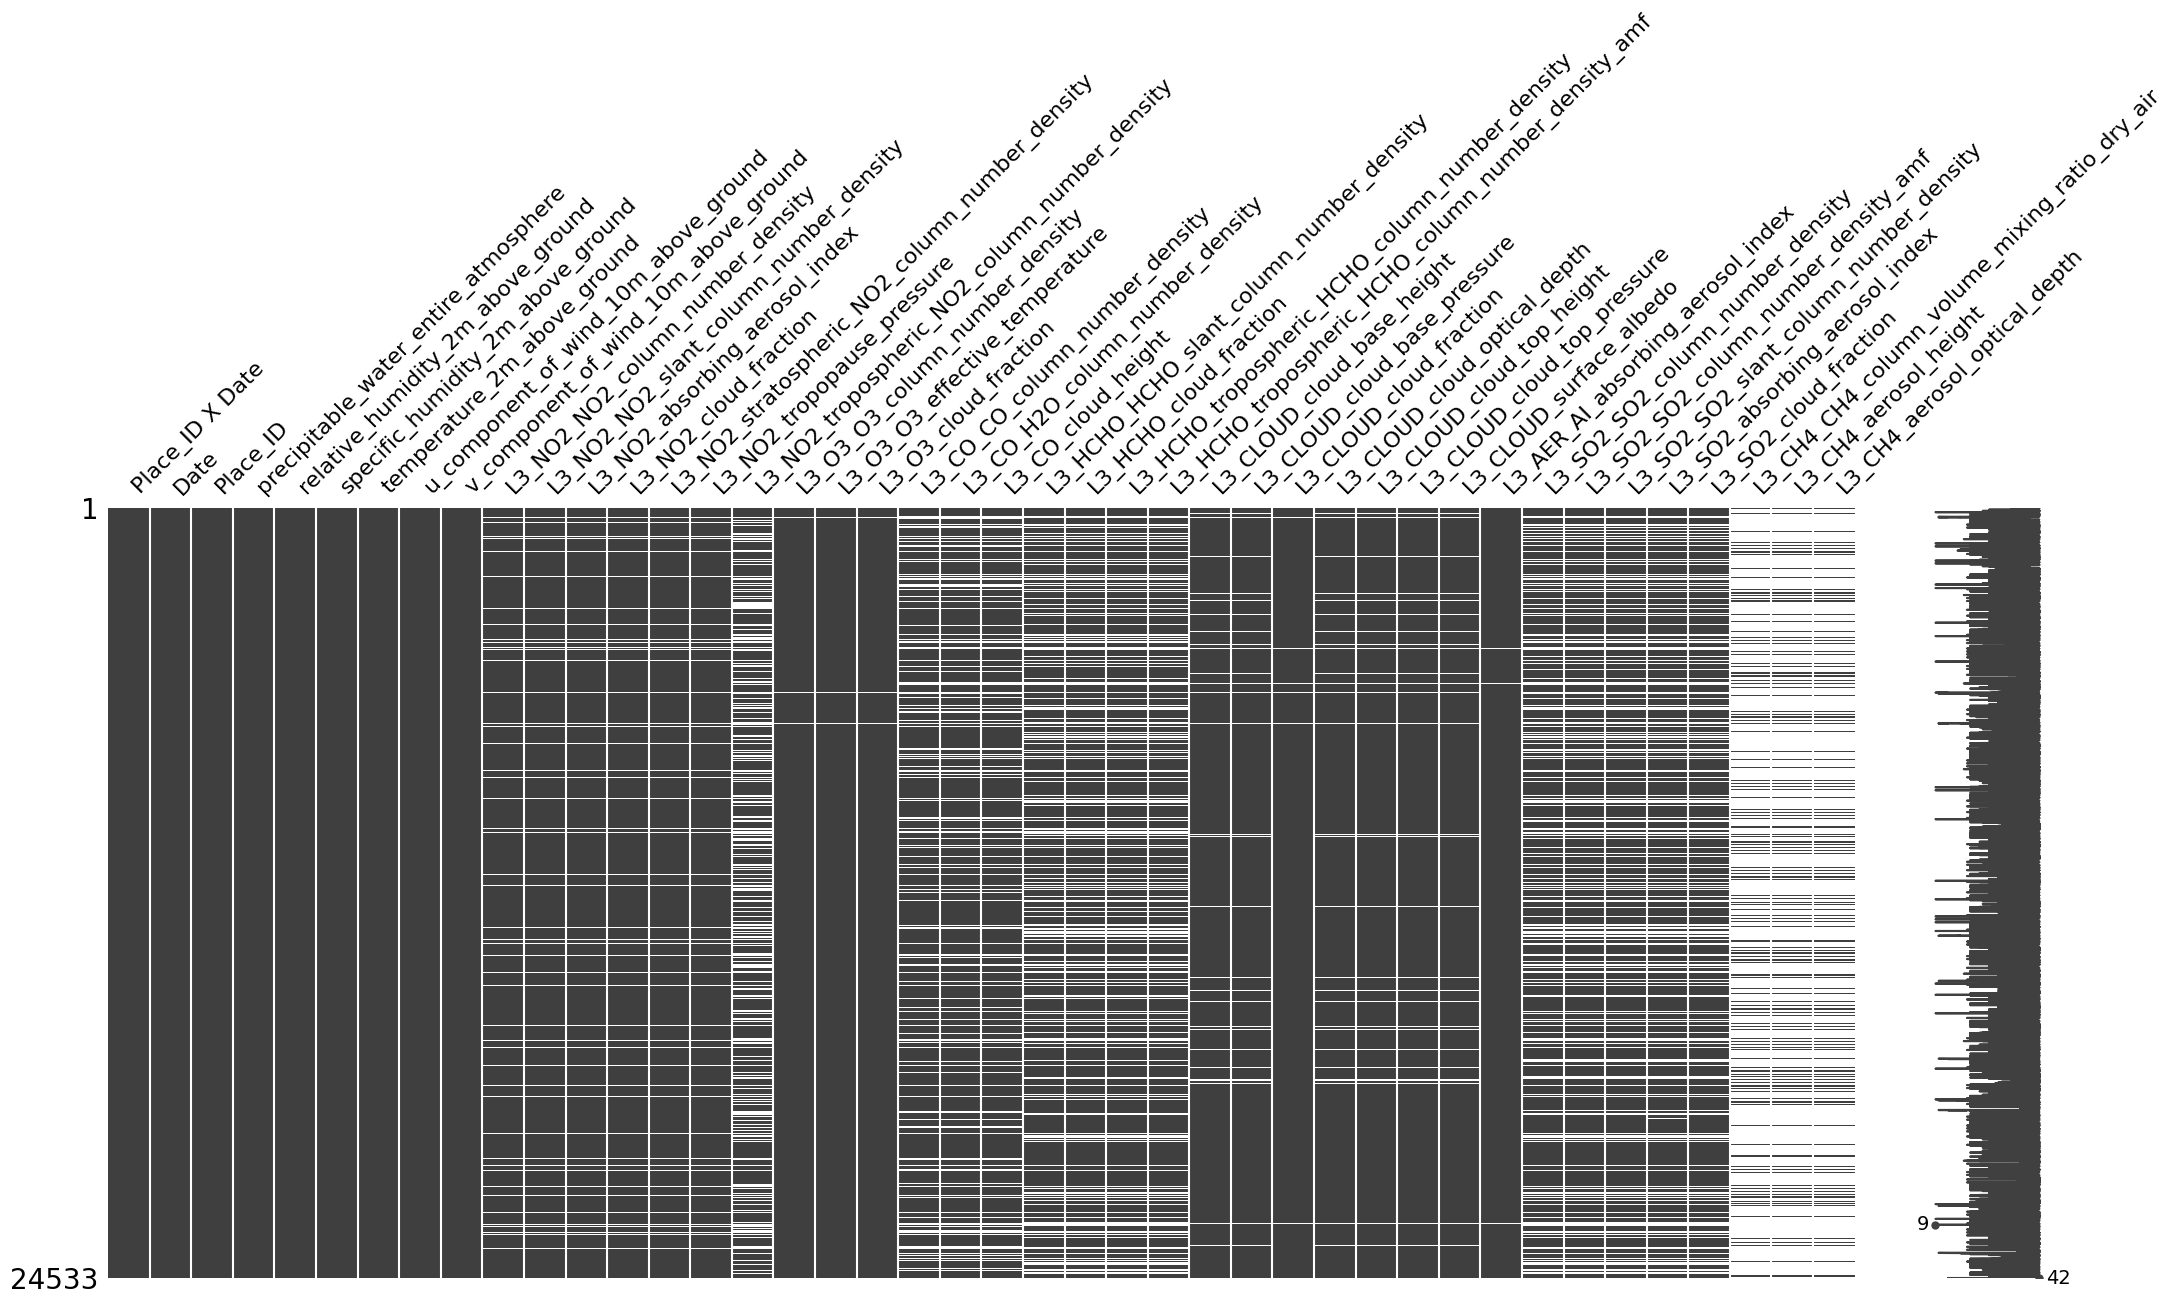

In [302]:
# assess missing values
msno.matrix(X_train)

<Axes: >

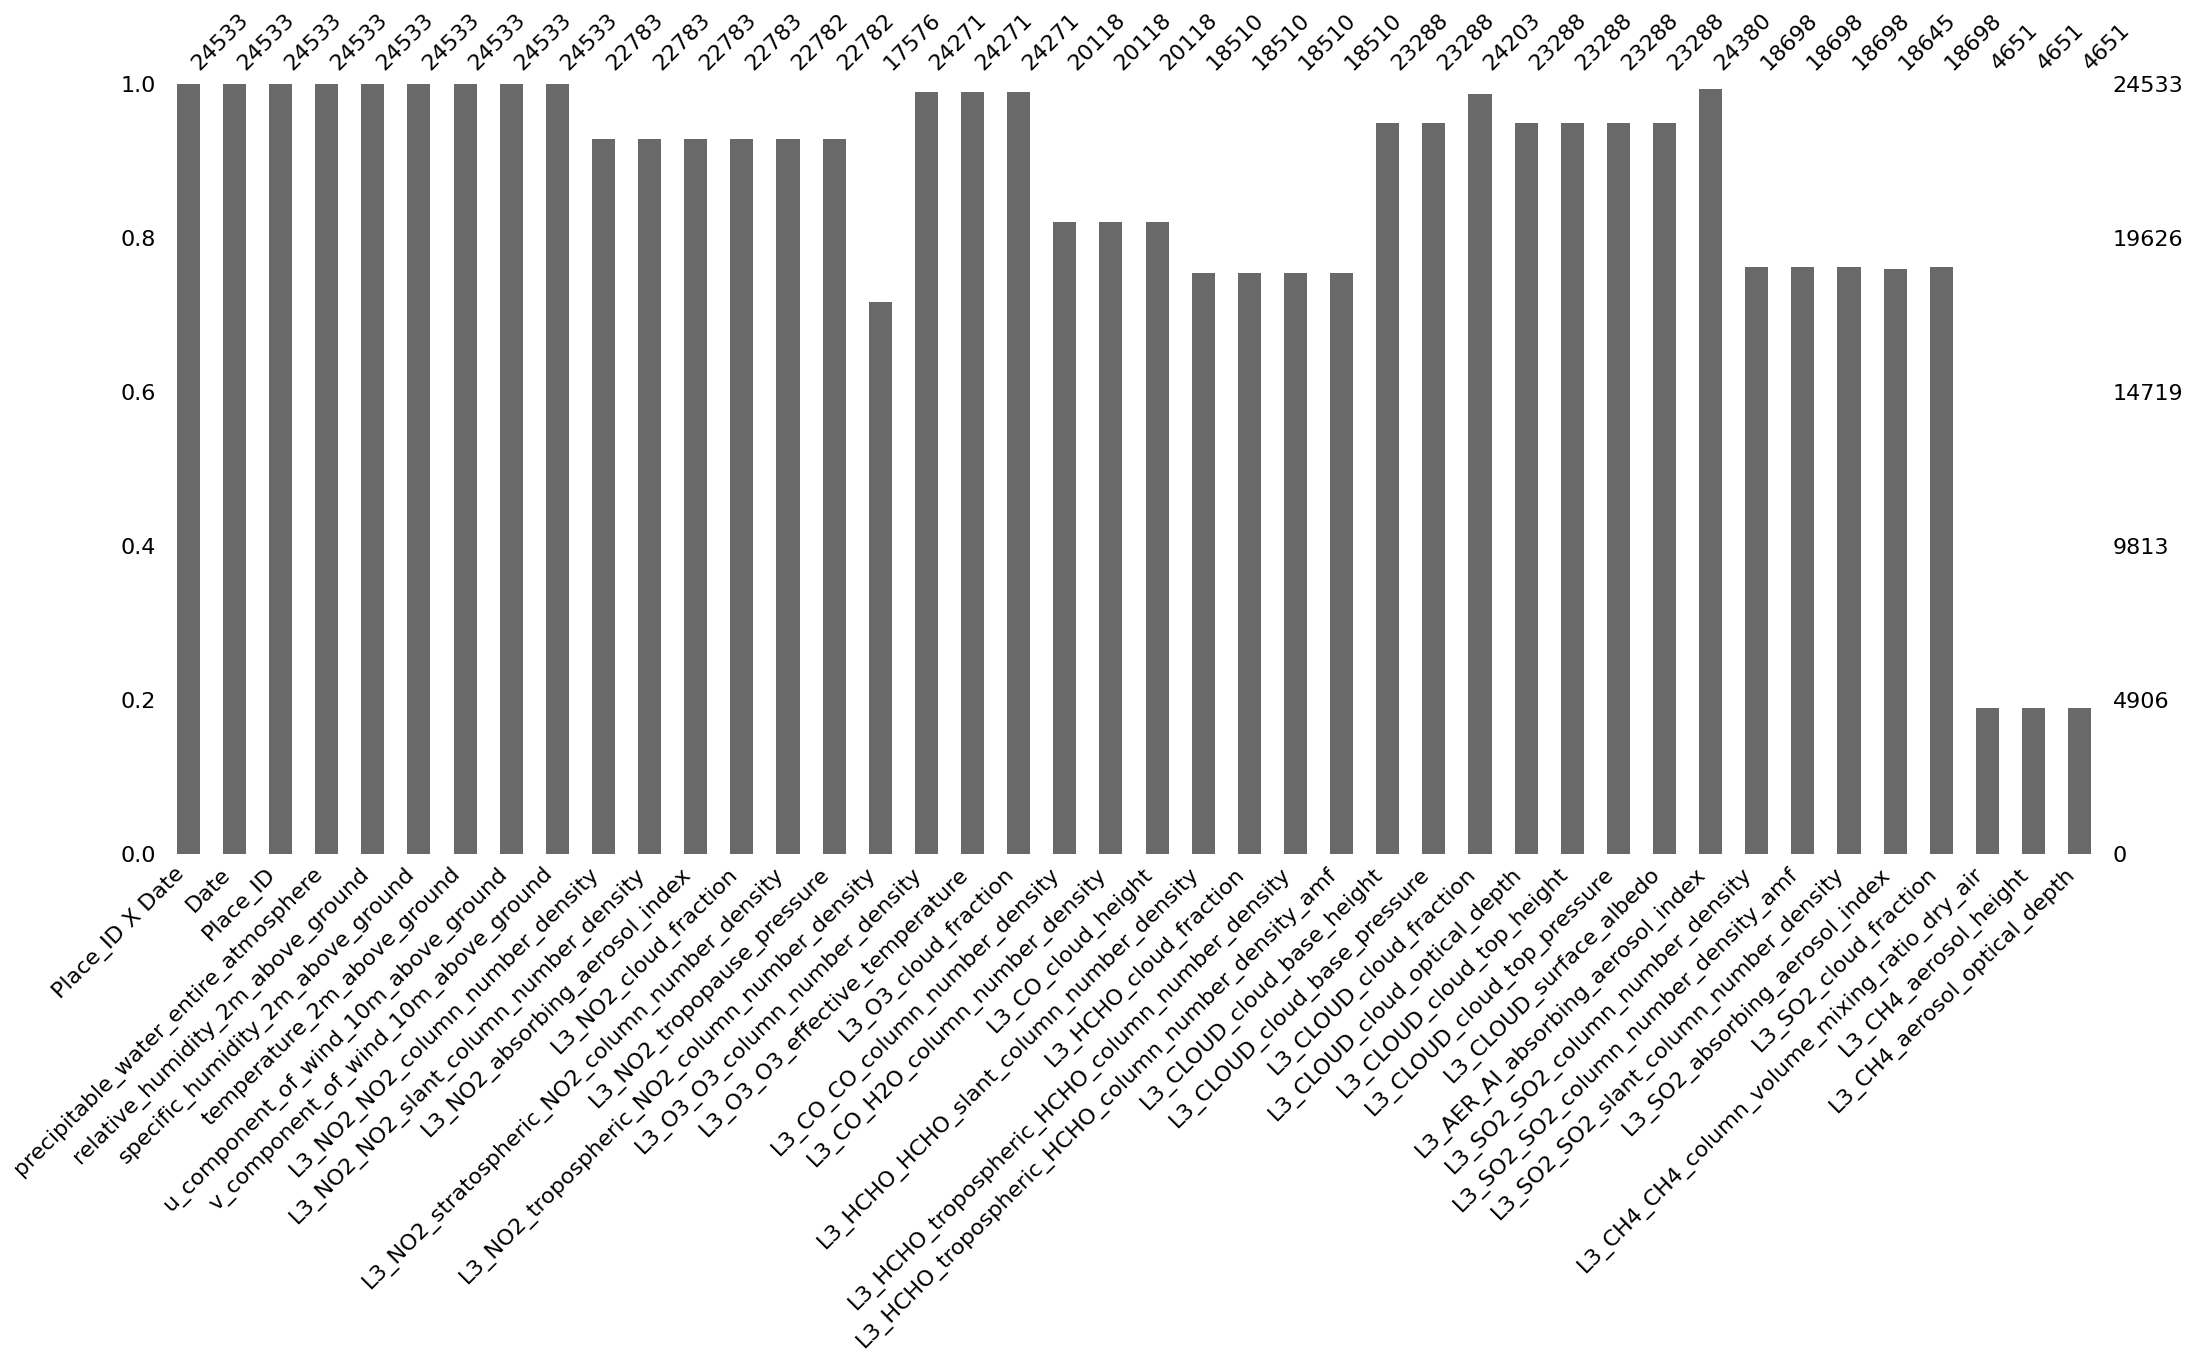

In [303]:
msno.bar(X_train)

!!MK finished cleaning code here!!

In [304]:
counts_missing = X.groupby('Place_ID').count().sort_values('L3_CH4_aerosol_height')

counts_missing.head(5)

,Place_ID X Date,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
Place_ID,,,,,,,,,,,,,,,,,,,,,
5IUK9TG,3,3,3,3,3,3,3,3,1,1,...,0,0,0,0,0,0,0,0,0,0
WY9VXCA,57,57,57,57,57,57,57,57,57,57,...,55,55,55,1,1,1,1,1,1,1
MJSB8K5,7,7,7,7,7,7,7,7,7,7,...,5,5,5,1,1,1,1,1,1,1
S91MBTB,29,29,29,29,29,29,29,29,28,28,...,17,17,17,1,1,1,1,1,1,1
SX68COZ,80,80,80,80,80,80,80,80,80,80,...,66,66,66,2,2,2,2,2,2,2


### Imputation for missing values
- we decided to use linear interpolation on the level of a place. 
- This means we need to: 
    - order data by place and date
    - interpolate 

In [305]:
# linear imputation of missing values
X_train.sort_values(['Place_ID X Date'])
X_test.sort_values(['Place_ID X Date'])

# Stepwise imputation: 
# 1. linear interpolation by place (back and forward)
                    
X_train_impute = X_train.groupby('Place_ID').apply(lambda group: group.interpolate(method='linear', limit_direction = 'both')).reset_index(drop = 1)
X_test_impute = X_test.groupby('Place_ID').apply(lambda group: group.interpolate(method='linear', limit_direction = 'both')).reset_index(drop = 1)

# 2. mean fill if no better option using simple imputer
impute_mean = SimpleImputer()
impute_mean.fit(X_train_impute[poll_cols])

X_train_impute[poll_cols] = impute_mean.transform(X_train_impute[poll_cols])
X_test_impute[poll_cols] = impute_mean.transform(X_test_impute[poll_cols])

# check on the one place for which we needed the simple imputer
# X_test_impute[X_test_impute.Place_ID == '5IUK9TG']


[visualization??]

In [312]:
# check that there are no missing values
assert X_train_impute.isnull().sum().sum() == 0
assert X_test_impute.isnull().sum().sum() == 0

In [316]:
# replace dataset with imputed dataset
X_train = X_train_impute.copy()
X_test = X_test_impute.copy()

# 4. Modelling

## Baseline model

- hypothesis: there is less PM2.5 in the atmosphere when it is windy
- method: OLS

- model
$$ y = b_0 + b_1 * x_1 + \epsilon $$

- estimated model
$$ PM_{2.5} = \hat{b}_0 + \hat{b}_1 * wind $$


In [283]:
# Baseline model

# select features
base_features = ['relative_humidity_2m_above_ground']

# fit linear regression
base = LinearRegression()
base.fit(X_train[base_features], y_train)

# predict values for test data
y_pred_base = base.predict(X_test[base_features])
e_base = y_test - y_pred_base

# predict values for train data (for checks)
y_pred_base_train = base.predict(X_train[base_features])

# calculate rmse of the model
rmse = mean_squared_error(y_test, y_pred_base, squared = False)
rmse

r2 = r2_score(y_test, y_pred_base)
print(r2)

# concat true and predicted values
base_plot = pd.DataFrame(np.c_[y_test, y_pred_base, e_base])
base_plot

# print model coefficients
print(f" The model is: \n PM2.5 = {base.coef_} + {base.intercept_[0]} * humidity")

# r2_score(y_train, y_pred_train)
base.coef_


0.005368992639439574
 The model is: 
 PM2.5 = [[-0.15215226]] + 70.79913762151058 * humidity


array([[-0.15215226]])

Text(0, 0.5, 'pm2.5')

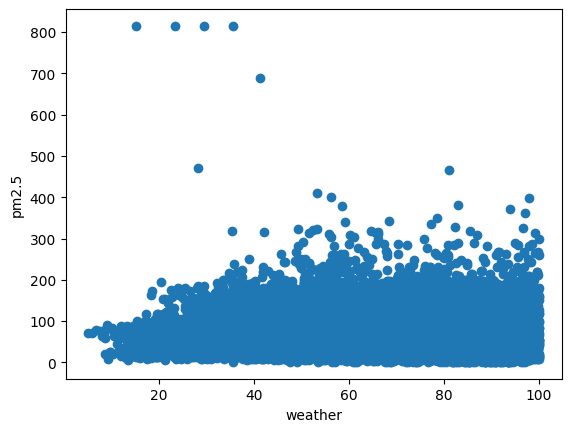

In [284]:
plt.scatter(X_train[base_features], y_train)
plt.xlabel('weather')
plt.ylabel('pm2.5')

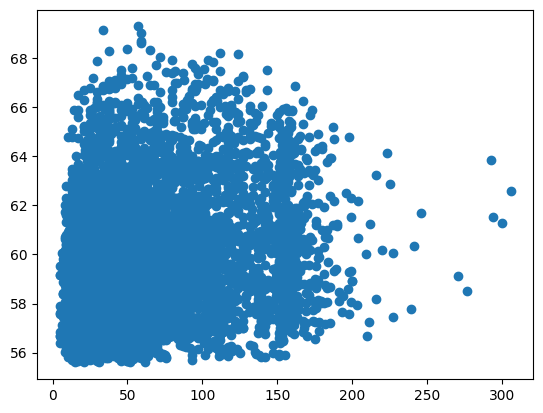

In [285]:
plt.scatter(y_test, y_pred_base)

## Advanced models

In [ ]:
models = [ols, knn, dt, rf]


In [287]:
## next: 
# 1. deal with corner values forward backward
# 2. deal with that one city which has 0 observations for CH4
# 3. plot results and celebrate

# # Plot imputed data
# linear_int['MaxSpeed'][:100].plot(color='red', marker='o', linestyle='dotted')
# df['MaxSpeed'][:100].plot(title='MaxSpeed', marker='o')

# splitting tasks: 
# - finish interpolation 
# - understand pollution variables & summary stastistics & correlations
# - scaling + feature engineering 
# - plan which model to use & implement 
# [- presentation]
